# Wstęp
Stworzone są nastepujące wykresy:
- Średnia ilość przeszkód na typ mapy (dla każdego poziomu)
- Najczęściej uderzane przeszkody (full) (dla każdego poziomu)
- Na której mapie najczęściej kończyła się rozgrywka (dla każdego poziomu)

In [2]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

con = sqlite3.connect("game_database.db")
cur = con.cursor()

sql_query = '''SELECT md.*, d.difficulty_level, ho.*, COUNT(*) as obstacles_count FROM MapData md
JOIN Obstacles o ON (o.position_z BETWEEN md.start AND md.end) AND (o.game_id = md.game_id)
LEFT JOIN Difficulties d ON md.game_id = d.game_id
LEFT JOIN (SELECT * FROM HitObstacles WHERE hit_type == "full") ho ON (md.game_id = ho.game_id) AND (ho.obstacle_position_z BETWEEN md.start AND md.end)
WHERE md.game_id NOT IN (SELECT d2.game_id FROM difficulties d2 GROUP BY d2.game_id HAVING COUNT(*) > 1)
GROUP BY md.game_id, md.map_type, md.start, md.end'''

df = pd.read_sql_query(sql_query, con)
print(df.head(5))

c:\Anaconda\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


   game_id            map_type  lane_change_prob  small_obs_prob  gate_prob  \
0       58    FirstObstacleMap               0.3             0.3       0.05   
1       58  SeventhObstacleMap               0.5             0.5       0.05   
2       58    SixthObstacleMap               0.5             0.6       0.10   
3       59    FifthObstacleMap               0.3             0.6       0.10   
4       59    FirstObstacleMap               0.5             0.5       0.05   

             color_theme  start   end  generation_dist  difficulty_level  \
0  COLOR_THEME_COLORFULL    500  2750              250                 2   
1      COLOR_THEME_BASIC   2500  4750              250                 2   
2      COLOR_THEME_BASIC   4750  6950              200                 2   
3      COLOR_THEME_BASIC    500  2750              250                 2   
4  COLOR_THEME_COLORFULL   6900  9100              200                 2   

   game_id  obstacle_name  side hit_type  obstacle_position_z  obsta

# Plotting

## Average obstacles per map

c:\Anaconda\lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
c:\Anaconda\lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
c:\Anaconda\lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


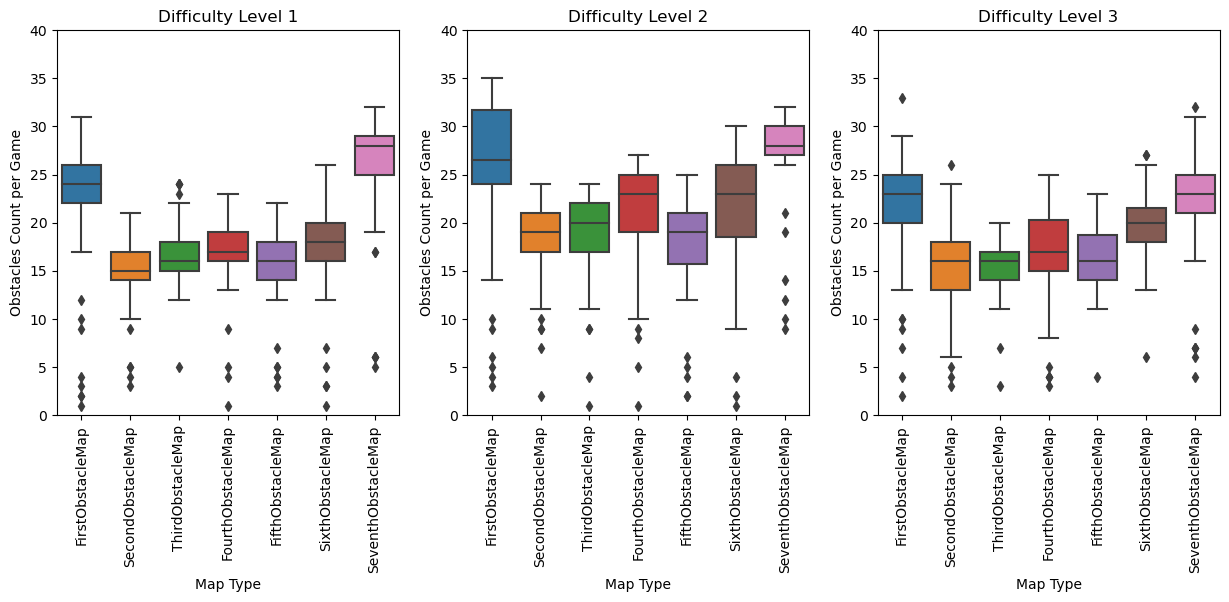

In [7]:
# plot average obstacles count per game for each difficulty level per map type  

# find max avg number of obstacles count per game for each difficulty level
# max_obstacles_count = df.groupby(['difficulty_level', 'map_type'])['obstacles_count'].mean().max()
max_obstacles_count = df['obstacles_count'].max()

# df_plot = df.groupby(['difficulty_level', 'map_type'])['obstacles_count'].mean().reset_index()
df_plot = df # for boxplot
df_plot['map_type'] = pd.Categorical(df_plot['map_type'], ['FirstObstacleMap', 'SecondObstacleMap', 'ThirdObstacleMap', 'FourthObstacleMap', 'FifthObstacleMap', 'SixthObstacleMap', 'SeventhObstacleMap'])
df_plot = df_plot.sort_values(by=['difficulty_level', 'map_type'])

fig, ax = plt.subplots(1,3,figsize=(15, 5))
for difficulty in df['difficulty_level'].unique():
    i = int(difficulty) - 1
    df_plot_difficulty = df_plot[df_plot['difficulty_level'] == difficulty]
    # sns.barplot(x='map_type', y='obstacles_count', data=df_plot_difficulty, ax=ax[i])
    sns.boxplot(x='map_type', y='obstacles_count', data=df_plot_difficulty, ax=ax[i])
    ax[i].set_title('Difficulty Level ' + str(difficulty))
    ax[i].set_xlabel('Map Type')
    ax[i].set_ylabel('Obstacles Count per Game')
    ax[i].set_ylim(0, max_obstacles_count + 5)
    for tick in ax[i].get_xticklabels():
        tick.set_rotation(90)

plt.show()

## Which obstacle ends a game the most

c:\Anaconda\lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
c:\Anaconda\lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
c:\Anaconda\lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


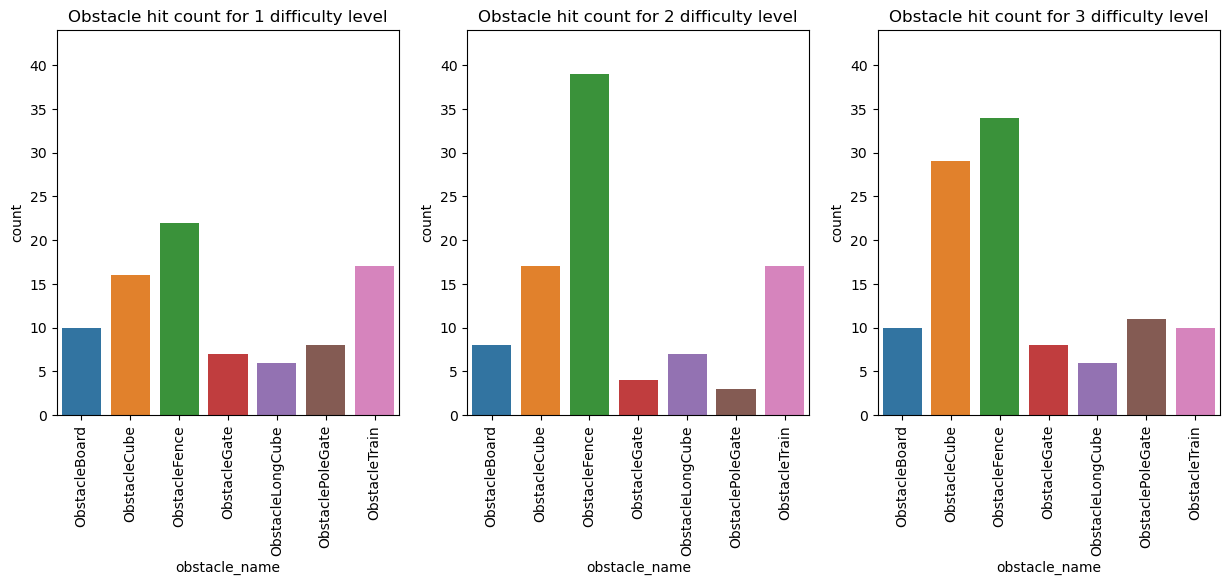

In [3]:
# plot which obstacle is hit the most for each difficulty level
df_plot = df[df['obstacle_name'].notnull()].loc[:, ['game_id','obstacle_name', 'obstacle_position_z', 'hit_type', 'map_type', 'difficulty_level']]
df_plot = df_plot.groupby(['difficulty_level', 'obstacle_name']).size().reset_index(name='count')
# set obstacle_name as categorical data type
df_plot['obstacle_name'] = df_plot['obstacle_name'].astype('category')
# df_plot = df_plot.sort_values(by=['difficulty_level', 'count'], ascending=False)
max_hit_count = df_plot.groupby('difficulty_level')['count'].max().max()

fig, ax = plt.subplots(1,3,figsize=(15, 5))
for difficulty in df['difficulty_level'].unique():
    i = int(difficulty) - 1
    df_plot_difficulty = df_plot[df_plot['difficulty_level'] == difficulty]
    sns.barplot(x='obstacle_name', y='count', data=df_plot_difficulty, ax=ax[i])
    # rotate x-axis labels
    for tick in ax[i].get_xticklabels():
        tick.set_rotation(90)
    ax[i].set_title(f'Obstacle hit count for {difficulty} difficulty level')
    # set y-axis limit to max + 5
    ax[i].set_ylim(0, max_hit_count + 5)

## Which map ends a game the most

    difficulty_level            map_type  count
1                  1    FirstObstacleMap     23
3                  1   SecondObstacleMap     24
6                  1    ThirdObstacleMap     16
2                  1   FourthObstacleMap     15
0                  1    FifthObstacleMap     17
5                  1    SixthObstacleMap     17
4                  1  SeventhObstacleMap     32
8                  2    FirstObstacleMap     15
10                 2   SecondObstacleMap     12
13                 2    ThirdObstacleMap     10
9                  2   FourthObstacleMap     15
7                  2    FifthObstacleMap     20
12                 2    SixthObstacleMap     14
11                 2  SeventhObstacleMap     25
15                 3    FirstObstacleMap     16
17                 3   SecondObstacleMap     23
20                 3    ThirdObstacleMap      5
16                 3   FourthObstacleMap     16
14                 3    FifthObstacleMap     10
19                 3    SixthObstacleMap

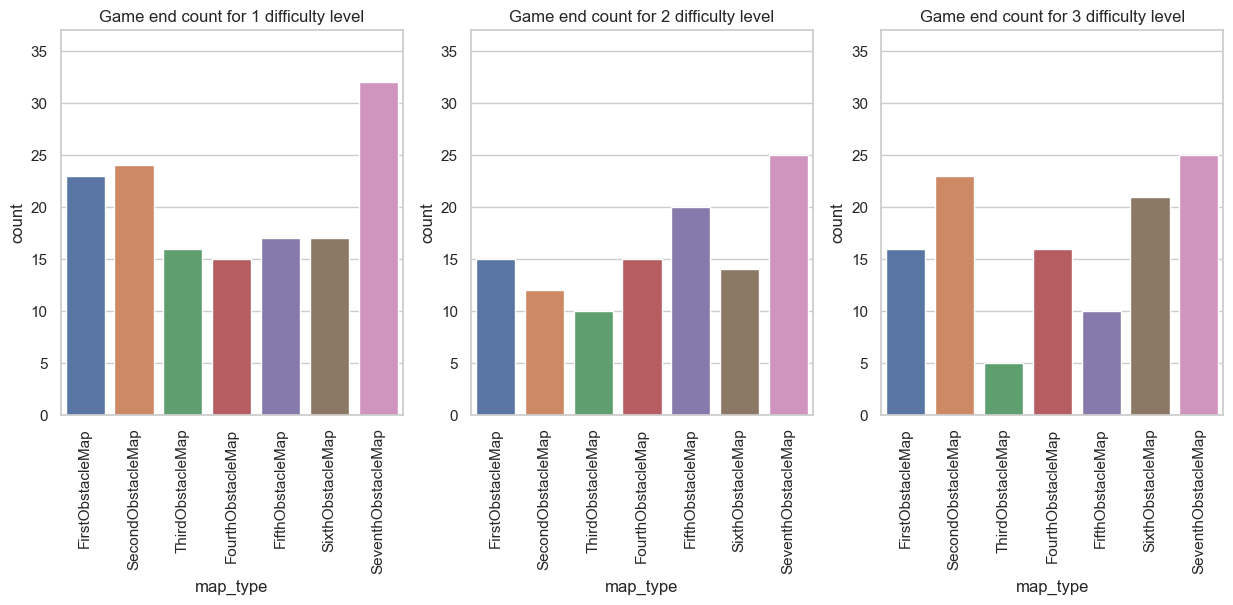

In [55]:
# Plot on which map type the game ends for each difficulty level

df_plot = df[df['hit_type'] == 'full'].loc[:, ['game_id', 'map_type', 'difficulty_level']]
df_plot = df_plot.groupby(['difficulty_level', 'map_type']).size().reset_index(name='count')
# df_plot = df_plot.sort_values(by=['difficulty_level', 'count'], ascending=False)
max_end_count = df_plot.groupby('difficulty_level')['count'].max().max()

# sort map_type by the order of "FirstObstacleMap", "SecondObstacleMap",..., "SeventhObstacleMap"
df_plot['map_type'] = pd.Categorical(df_plot['map_type'], ['FirstObstacleMap', 'SecondObstacleMap', 'ThirdObstacleMap', 'FourthObstacleMap', 'FifthObstacleMap', 'SixthObstacleMap', 'SeventhObstacleMap'])
df_plot = df_plot.sort_values(by=['difficulty_level', 'map_type'])

fig, ax = plt.subplots(1,3,figsize=(15, 5))
for difficulty in df['difficulty_level'].unique():
    i = int(difficulty) - 1
    df_plot_difficulty = df_plot[df_plot['difficulty_level'] == difficulty]
    sns.barplot(x='map_type', y='count', data=df_plot_difficulty, ax=ax[i])
    # rotate x-axis labels
    for tick in ax[i].get_xticklabels():
        tick.set_rotation(90)
    ax[i].set_title(f'Game end count for {difficulty} difficulty level')
    # set y-axis limit to max + 5
    ax[i].set_ylim(0, max_end_count + 5)


## Map distribiution

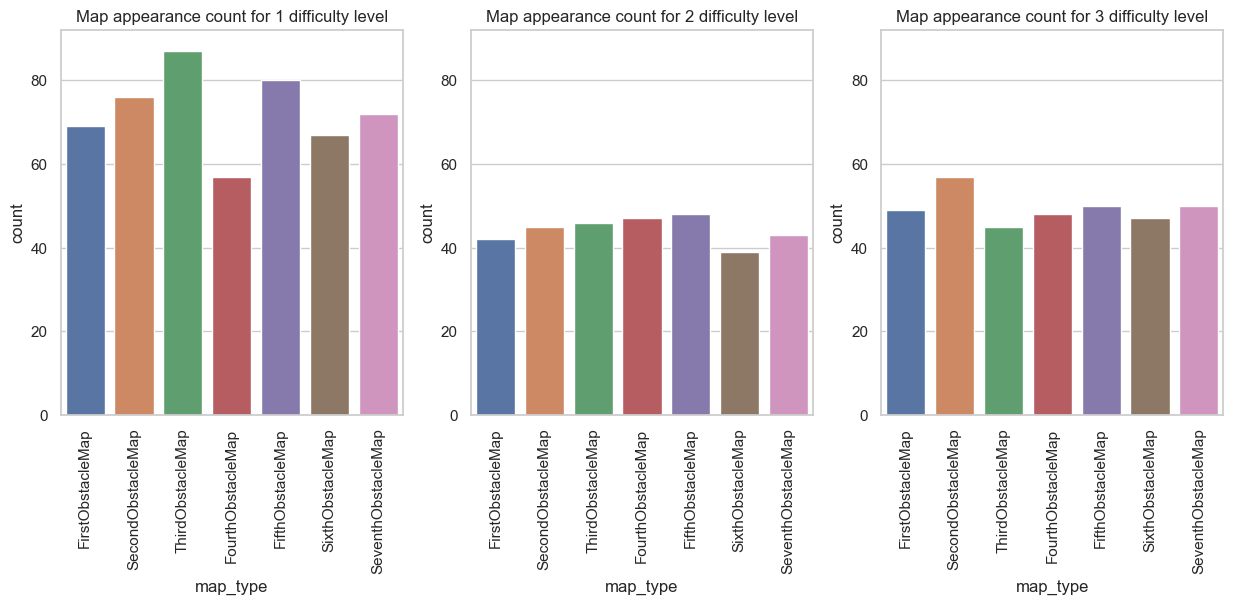

In [65]:
# Plot each map appearance count for each difficulty level
df_plot = df.loc[:, ['game_id', 'map_type', 'difficulty_level']]
df_plot = df_plot.groupby(['difficulty_level', 'map_type']).size().reset_index(name='count')
# df_plot = df_plot.sort_values(by=['difficulty_level', 'count'], ascending=False)
max_map_count = df_plot.groupby('difficulty_level')['count'].max().max()

# sort map_type by the order of "FirstObstacleMap", "SecondObstacleMap",..., "SeventhObstacleMap"
df_plot['map_type'] = pd.Categorical(df_plot['map_type'], ['FirstObstacleMap', 'SecondObstacleMap', 'ThirdObstacleMap', 'FourthObstacleMap', 'FifthObstacleMap', 'SixthObstacleMap', 'SeventhObstacleMap'])
df_plot = df_plot.sort_values(by=['difficulty_level', 'map_type'])

fig, ax = plt.subplots(1,3,figsize=(15, 5))
for difficulty in df['difficulty_level'].unique():
    i = int(difficulty) - 1
    df_plot_difficulty = df_plot[df_plot['difficulty_level'] == difficulty]
    sns.barplot(x='map_type', y='count', data=df_plot_difficulty, ax=ax[i])
    # rotate x-axis labels
    for tick in ax[i].get_xticklabels():
        tick.set_rotation(90)
    ax[i].set_title(f'Map appearance count for {difficulty} difficulty level')
    # set y-axis limit to max + 5
    ax[i].set_ylim(0, max_map_count + 5)

## Which map ends a game the most (normalized by appearance count)

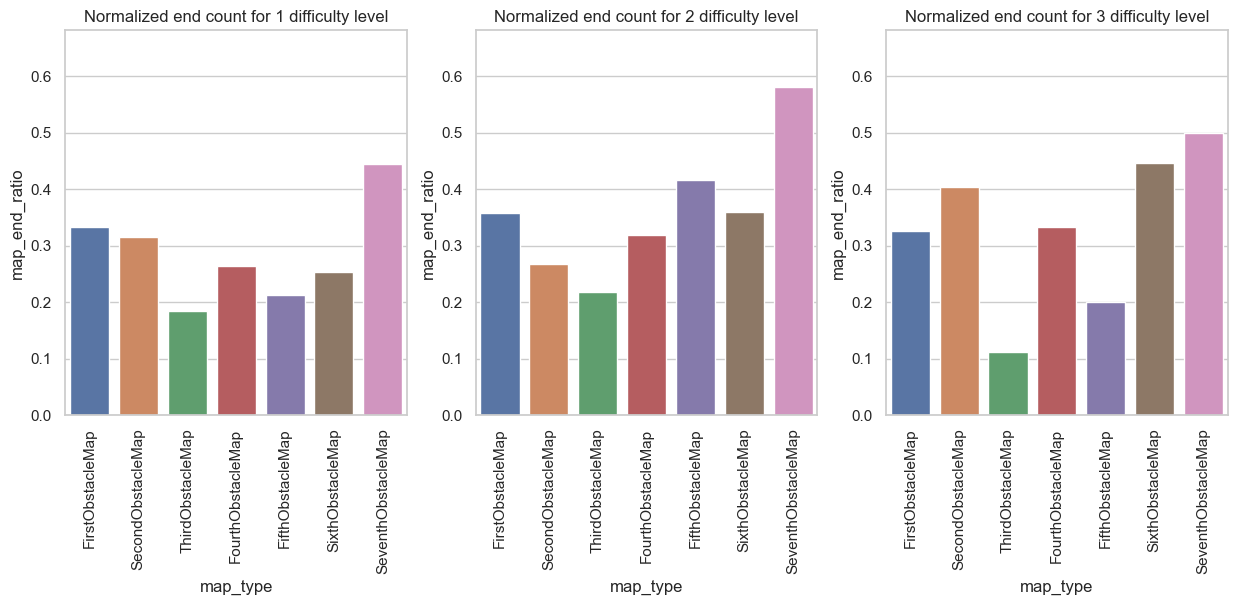

In [91]:
df_plot = df[df['hit_type'] == 'full'].loc[:, ['game_id', 'map_type', 'difficulty_level']]
df_plot = df_plot.groupby(['difficulty_level', 'map_type']).size().reset_index(name='map_end_count')

df_plot2 = df.loc[:, ['game_id', 'map_type', 'difficulty_level']]
df_plot2 = df_plot2.groupby(['difficulty_level', 'map_type']).size().reset_index(name='map_appearance_count')

# merge two dataframes
df_plot = pd.merge(df_plot, df_plot2, on=['difficulty_level', 'map_type'], )
df_plot['map_end_ratio'] = df_plot['map_end_count'] / df_plot['map_appearance_count']
max_end_count = df_plot['map_end_ratio'].max()

# sort map_type by the order of "FirstObstacleMap", "SecondObstacleMap",..., "SeventhObstacleMap"
df_plot['map_type'] = pd.Categorical(df_plot['map_type'], ['FirstObstacleMap', 'SecondObstacleMap', 'ThirdObstacleMap', 'FourthObstacleMap', 'FifthObstacleMap', 'SixthObstacleMap', 'SeventhObstacleMap'])
df_plot = df_plot.sort_values(by=['difficulty_level', 'map_type'])

fig, ax = plt.subplots(1,3,figsize=(15, 5))
for difficulty in df['difficulty_level'].unique():
    i = int(difficulty) - 1
    df_plot_difficulty = df_plot[df_plot['difficulty_level'] == difficulty]
    sns.barplot(x='map_type', y='map_end_ratio', data=df_plot_difficulty, ax=ax[i])
    # rotate x-axis labels
    for tick in ax[i].get_xticklabels():
        tick.set_rotation(90)
    ax[i].set_title(f'Normalized end count for {difficulty} difficulty level')
    # set y-axis limit to max + 5
    ax[i].set_ylim(0, max_end_count + 0.1)